# Fast Agent - Build a SQL Agent fast!
> **Disclaimer**  
> This notebook uses content adapted from a course-provided notebook available at [github.com/langchain-ai/lca-langchainV1-essentials](https://github.com/langchain-ai/lca-langchainV1-essentials).  
> All original credit belongs to the course authors.

## Setup

In [1]:
from dotenv import load_dotenv
load_dotenv()

from bedrock import nova_pro as llm

from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

## Agent Creation

Define the runtime context to provide the agent and tools with access to the database.

In [2]:
from dataclasses import dataclass
from langchain_community.utilities import SQLDatabase

# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

Define tool for sql execution

In [3]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Define system prompt

In [4]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create agent with a model + tool + system_prompt + runtime_access

In [11]:
# AGENT CREATION

from langchain.agents import create_agent
from langchain_aws import ChatBedrockConverse

agent = create_agent(
    model=llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)
# context_schema tells the agent “Hey — I expect the runtime to have this shape / these fields,” 
# so that inside your tools or middleware, you can safely refer to runtime.context.whatever_field.

## Execute agent

Here's a display of the agent ReAct Loop.

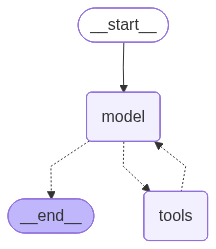

In [12]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [13]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================

[{'type': 'text', 'text': "<thinking> To determine which table has the largest number of entries, I need to first list all the tables in the database and then count the number of entries in each table. However, since I can only execute one SELECT query at a time and I don't know the table names in advance, I'll start by listing all the tables. Once I have the table names, I can proceed to count the number of entries in each table. </thinking>\n"}, {'type': 'tool_use', 'name': 'execute_sql', 'input': {'query': "SELECT name FROM sqlite_master WHERE type='table';"}, 'id': 'tooluse_2D-PZoIoSlO61xAgzRSAjQ'}]
Tool Calls:
  execute_sql (tooluse_2D-PZoIoSlO61xAgzRSAjQ)
 Call ID: tooluse_2D-PZoIoSlO61xAgzRSAjQ
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
========

In [14]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> To determine which genre has the longest tracks on average, I need to perform the following steps:\n1. Identify the columns in the database that contain genre and track length information.\n2. Calculate the average track length for each genre.\n3. Determine which genre has the highest average track length.\n\nFirst, I need to identify the columns that contain the necessary information. </thinking>\n'}, {'type': 'tool_use', 'name': 'execute_sql', 'input': {'query': "SELECT name FROM PRAGMA_TABLE_INFO('tracks')"}, 'id': 'tooluse_YEznIZXqRSKvtP8pA7JxHg'}]
Tool Calls:
  execute_sql (tooluse_YEznIZXqRSKvtP8pA7JxHg)
 Call ID: tooluse_YEznIZXqRSKvtP8pA7JxHg
  Args:
    query: SELECT name FROM PRAGMA_TABLE_INFO('tracks')
============================

In [15]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================

[{'type': 'text', 'text': "<thinking> To list all of the tables in the SQLite database, I need to query the SQLite_master table, which contains metadata about the database schema. Specifically, I will select the 'name' column from the SQLite_master table where the 'type' is 'table'. This will give me a list of all table names in the database. </thinking>\n"}, {'type': 'tool_use', 'name': 'execute_sql', 'input': {'query': "SELECT name FROM SQLite_master WHERE type='table'"}, 'id': 'tooluse_VZjhwN3mRQiXZ1NrVhFM9g'}]
Tool Calls:
  execute_sql (tooluse_VZjhwN3mRQiXZ1NrVhFM9g)
 Call ID: tooluse_VZjhwN3mRQiXZ1NrVhFM9g
  Args:
    query: SELECT name FROM SQLite_master WHERE type='table'
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Ar

In [16]:
question = "Which is the longest song in the database?"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which is the longest song in the database?
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> To find the longest song in the database, I need to determine which song has the highest duration. I should query the database for the song title and duration, ordering the results by duration in descending order and limiting the output to the top row. </thinking>\n'}, {'type': 'tool_use', 'name': 'execute_sql', 'input': {'query': 'SELECT title, duration FROM songs ORDER BY duration DESC LIMIT 1'}, 'id': 'tooluse_s3sGgDHpRT-78XnYGI-JOQ'}]
Tool Calls:
  execute_sql (tooluse_s3sGgDHpRT-78XnYGI-JOQ)
 Call ID: tooluse_s3sGgDHpRT-78XnYGI-JOQ
  Args:
    query: SELECT title, duration FROM songs ORDER BY duration DESC LIMIT 1
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalE

### To try on studio:
1. Run ```langraph dev``` on terminal
2. Open Studio UI url